In [1]:
from abc import ABC, abstractmethod
import numpy as np
import torch.nn as nn
import torch

In [2]:
class PointProcess(ABC):    
    pass

In [ ]:
for t in range(1, n_points):
    # X2 is more likely to happen if X1 happened in the previous step
    X2[t] = np.random.binomial(1, 0.5 * X1[t-1])
    # X3 is more likely to happen if X2 happened in the previous step
    X3[t] = np.random.binomial(1, 0.7 * X2[t-1] )

In [4]:
class BinomialTriangular(PointProcess):

    def __init__(self, num_processes, num_points, base_factor, **kwargs):
        
        np.random.seed(42)
        self.num_processes = num_processes        
        self.num_points = num_points    
        self.time = np.arange(num_points)
        self.processes = []
        
        process_base = np.random.binomial(1, base_factor, num_points)        
        matrix = np.zeros(shape = (num_processes, num_points))
        matrix[0, :] = process_base
        
        influence_rank = kwargs.get('influence_rank')
        self.memory_size = 4
        
        if influence_rank is None:
            range_size = 0.5
            min_val = 0.49
            influence_rank = np.random.rand(self.num_processes - 1)*range_size + min_val
        
        assert len(influence_rank) == (self.num_processes - 1), 'influence rank length must be equal to the number of processes - 1'
        self.influence_rank = influence_rank
        
        
        def _generate_data(matrix):
            for t in range(1, self.num_points):
                for j in range(1, self.num_processes):
                    # assert 
                    matrix[j, t] = np.random.binomial(1, self.influence_rank[j-1]*matrix[j-1, t])
            return matrix
        
        self.matrix = _generate_data(matrix)
        
        def _turn_into_time(matrix):
            thold = 0.2
            matrix_times = []
            for j in range(0, self.num_processes):
                matrix_times.append([self.time[i] + thold for i in range(self.num_points) if matrix[j, i] > 0 ])
            return matrix_times
        
        self.matrix_times = _turn_into_time(self.matrix)
            

        self.memory_size = 4
        
        def _timestamp_of_start(matrix_times):
            
            timestamps_of_influence_begin = []
            for i in range(self.num_processes):
                timestamps_of_influence_begin.append(self.matrix_times[i][self.memory_size])
            
            return timestamps_of_influence_begin
        
        self.timestamps_of_influence_begin = _timestamp_of_start(self.matrix_times)


        def _make_sweep_dict(matrix_times):
            def _sweep(self, pa, pc):
                events = []
                pa_indices = []


                for i, ia in enumerate(pa):
                    events.append((ia, 'a'))
                    pa_indices.append(i)

                for ic in pc:
                    events.append((ic, 'c'))

                lim = self.memory_dim

                events.sort()
                mem = []
                ret = []
                index_start = False

                pa_idx_counter = 0  

                for t, e in events:
                    if e == 'c':
                        if len(mem) >= lim:
                            mem.pop(0)
                        mem.append(t)

                    if e == 'a':
                        
                        if len(mem) < lim:
                            pa_idx_counter += 1  
                            continue
                        
                        pp = [t - tc for tc in mem]
                        ret.append(pp)
                        if not index_start:
                            index_start = pa_indices[pa_idx_counter] 
                            pa_idx_counter += 1 
                
                if not index_start:
                    index_start = -1
                
                return torch.tensor(ret, dtype=torch.float), index_start
                
    
    def get_events(self, num_events, idx_start, idx_process_base):

        curr_process = self.matrix_times[idx_process_base]
        ret = []
        for i in range(idx_start, idx_start + num_events):
            curr_time = curr_process[i]
            for j in range(self.num_processes):
                if curr_time >= self.timestamps_of_influence_begin[j] and curr_time <= self.matrix_times[j][-1]: ## check if at this timestamp, 
                    # app the sweep dict of this process
                    ret.append((0.3, j))
                else:
                    continue
                    # process can not cause this one.
        return ret



            

            

In [114]:
class GetEvents:

    def __init__(self):
        pass

    def get(self, sweep_dict, idx_start)

1

In [5]:
teste = BinomialTriangular(num_processes=3, num_points = 1200, base_factor=0.6)

In [98]:
teste.get_events(num_events=2, idx_start = 5, idx_process_base = 0)

[(0.3, 0), (0.3, 0), (0.3, 1)]

In [116]:
torch.empty(size = (10,2))

tensor([[2.1707e-18, 7.0952e+22],
        [1.7748e+28, 1.8176e+31],
        [7.2708e+31, 5.0778e+31],
        [3.2608e-12, 1.7728e+28],
        [7.0367e+22, 2.1715e-18],
        [3.3381e-09, 2.6394e-09],
        [8.4030e+20, 6.5548e-10],
        [1.9969e+20, 1.0368e-11],
        [2.0547e+20, 2.0317e+20],
        [4.3010e-05, 2.1707e-18]])

In [118]:
X1 = np.random.binomial(1, 0.6, 20)
X2 = np.zeros(20)
X3 = np.zeros(20)
time = np.arange(20)

for t in range(1, 20):
    # X2 is more likely to happen if X1 happened in the previous step
    X2[t] = np.random.binomial(1, 0.5 * X1[t-1] + 0.2)
    # X3 is more likely to happen if X2 happened in the previous step
    X3[t] = np.random.binomial(1, 0.7 * X2[t-1] + 0.2)



X1 = [time[i] for i in range(len(X1)) if X1[i] > 0]
X2 = [time[i] + 0.1 for i in range(len(X2)) if X2[i] > 0]
X3 = [time[i] + 0.2 for i in range(len(X3)) if X3[i] > 0]

def _sweep(pa, pc):
    events = []
    pa_indices = []


    for i, ia in enumerate(pa):
        events.append((ia, 'a'))
        pa_indices.append(i)

    for ic in pc:
        events.append((ic, 'c'))

    lim = 4

    events.sort()
    mem = []
    ret = []
    index_start = False
    ret_ = torch.empty(size = (10,4))
    pa_idx_counter = 0  

    for t, e in events:
        if e == 'c':
            if len(mem) >= lim:
                mem.pop(0)
            mem.append(t)
            ret.append([-1, -1, -1, -1])
            

        if e == 'a':
            
            if len(mem) < lim:
                pa_idx_counter += 1  
                continue
            
            pp = [t - tc for tc in mem]
            ret.append(pp)
            if not index_start:
                index_start = pa_indices[pa_idx_counter] 
                pa_idx_counter += 1 
    
    if not index_start:
        index_start = -1
    
    return torch.tensor(ret, dtype=torch.float), index_start

In [119]:
_sweep(X1,X2)

(tensor([[-1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000],
         [ 7.9000,  6.9000,  3.9000,  1.9000],
         [ 8.9000,  7.9000,  4.9000,  2.9000],
         [-1.0000, -1.0000, -1.0000, -1.0000],
         [ 8.9000,  5.9000,  3.9000,  0.9000],
         [10.9000,  7.9000,  5.9000,  2.9000],
         [-1.0000, -1.0000, -1.0000, -1.0000],
         [ 9.9000,  7.9000,  4.9000,  0.9000],
         [12.9000, 10.9000,  7.9000,  3.9000],
         [13.9000, 11.9000,  8.9000,  4.9000],
         [-1.0000, -1.0000, -1.0000, -1.0000]]),
 3)

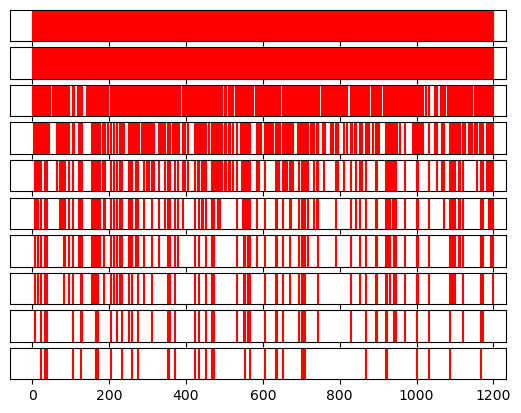

In [83]:
teste = BinomialTriangular(num_processes=10, num_points = 1200, base_factor=0.9)

import matplotlib.pyplot as plt 

def _plot_tick_bars(timestamps_i, ax, color):
    for t in timestamps_i:
        ax.axvline(x=t, color = color)
    # ax.set_title(label, fontsize=20)
    ax.get_yaxis().set_visible(False)
def _plot_tick_bars_causes(timestamps_i, ax, cause):
    colors = ['red', 'green', 'blue']
    for idx, t in enumerate(timestamps_i):
        cause_ = torch.argmax(cause[idx]).item()
        ax.axvline(x=t, color = colors[cause_])
    ax.get_yaxis().set_visible(False)

fig, ax = plt.subplots(nrows = 10, sharex = True)

for i in range(10):
    _plot_tick_bars(teste.matrix_times[i], ax[i], color = 'red')
# _plot_tick_bars(teste.matrix_times[1], ax[1], color = 'green')
# _plot_tick_bars(teste.matrix_times[2], ax[2], color = 'blue')

In [81]:
teste.influence_rank

array([0.8691316 , 0.50229346, 0.50106178, 0.65180511, 0.7343216 ,
       0.87520371, 0.83164769, 0.71295135, 0.62681333])